<a href="https://colab.research.google.com/github/roshanjain379-ux/SCT_DS_3/blob/main/Internship_task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve, auc
)

In [ ]:
data_path = "bank-full.csv" if os.path.exists("/content/bank-full.csv") else "bank.csv"
df = pd.read_csv(data_path, sep=";")

print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (45211, 17)
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [ ]:
target = "y"
X = df.drop(columns=[target])
y = df[target].map({"yes": 1, "no": 0}).astype(int)

# Separate numeric and categorical columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [ ]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
pipe = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=42))
])

# Smaller hyperparameter grid for speed
param_grid = {
    "clf__max_depth": [5, 7],
    "clf__min_samples_split": [5, 10],
    "clf__min_samples_leaf": [1, 2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="f1", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best = grid.best_estimator_
print("Best parameters:", grid.best_params_)
print("Best CV F1 score:", grid.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'clf__max_depth': 7, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5}
Best CV F1 score: 0.47743869041382503


In [ ]:
y_pred = best.predict(X_test)
y_proba = best.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("\n=== Test Set Metrics ===")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual No", "Actual Yes"], columns=["Pred No", "Pred Yes"])
print("\nConfusion Matrix:\n", cm_df)



=== Test Set Metrics ===
Accuracy: 0.8988
Precision: 0.6078
Recall: 0.3809
F1 Score: 0.4683
ROC AUC: 0.8642

Classification Report:
              precision    recall  f1-score   support

           0     0.9218    0.9674    0.9441      7985
           1     0.6078    0.3809    0.4683      1058

    accuracy                         0.8988      9043
   macro avg     0.7648    0.6742    0.7062      9043
weighted avg     0.8851    0.8988    0.8884      9043


Confusion Matrix:
             Pred No  Pred Yes
Actual No      7725       260
Actual Yes      655       403


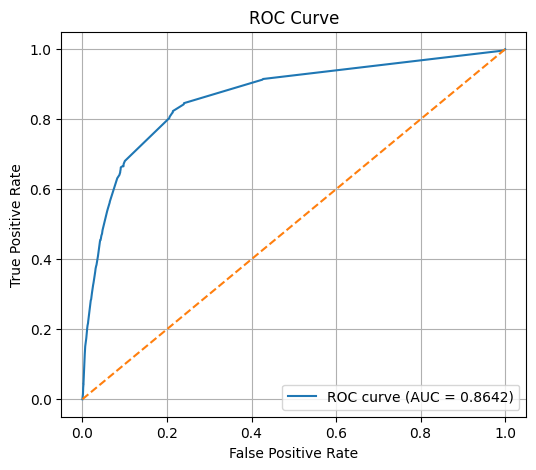

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_val:.4f})")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Top 20 Important Features:
              feature  importance
3            duration    0.484661
49   poutcome_success    0.254047
5               pdays    0.046230
28         housing_no    0.038094
0                 age    0.037925
2                 day    0.022277
42          month_mar    0.022266
35          month_apr    0.021567
1             balance    0.014527
34    contact_unknown    0.009891
45          month_oct    0.008699
29        housing_yes    0.007186
43          month_may    0.005343
32   contact_cellular    0.003743
46          month_sep    0.003015
4            campaign    0.003004
41          month_jun    0.002851
20    marital_married    0.002185
22  education_primary    0.002077
30            loan_no    0.001771


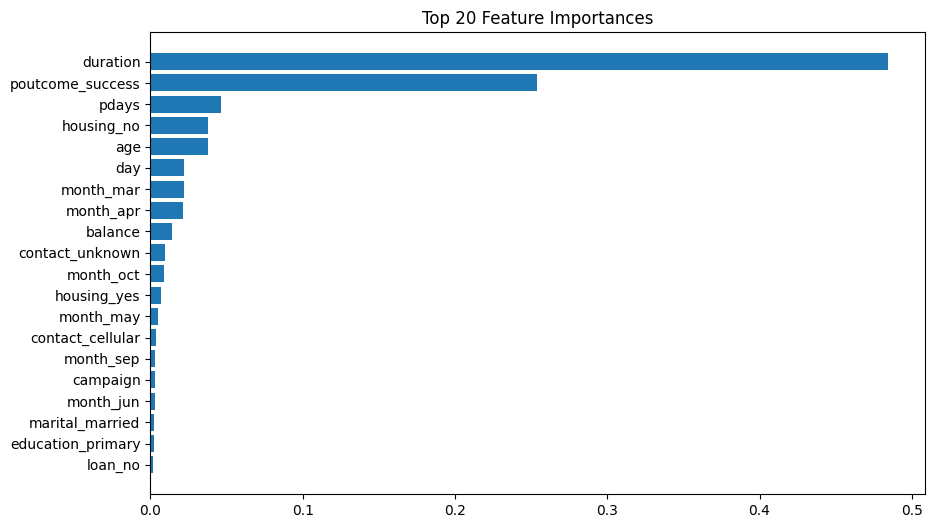

In [ ]:
ohe = best.named_steps["pre"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = list(ohe.get_feature_names_out(categorical_cols))
feature_names = numeric_cols + cat_feature_names
importances = best.named_steps["clf"].feature_importances_

feat_imp = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_imp = feat_imp.sort_values(by="importance", ascending=False).head(20)

print("\nTop 20 Important Features:")
print(feat_imp)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feat_imp["feature"], feat_imp["importance"])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.show()


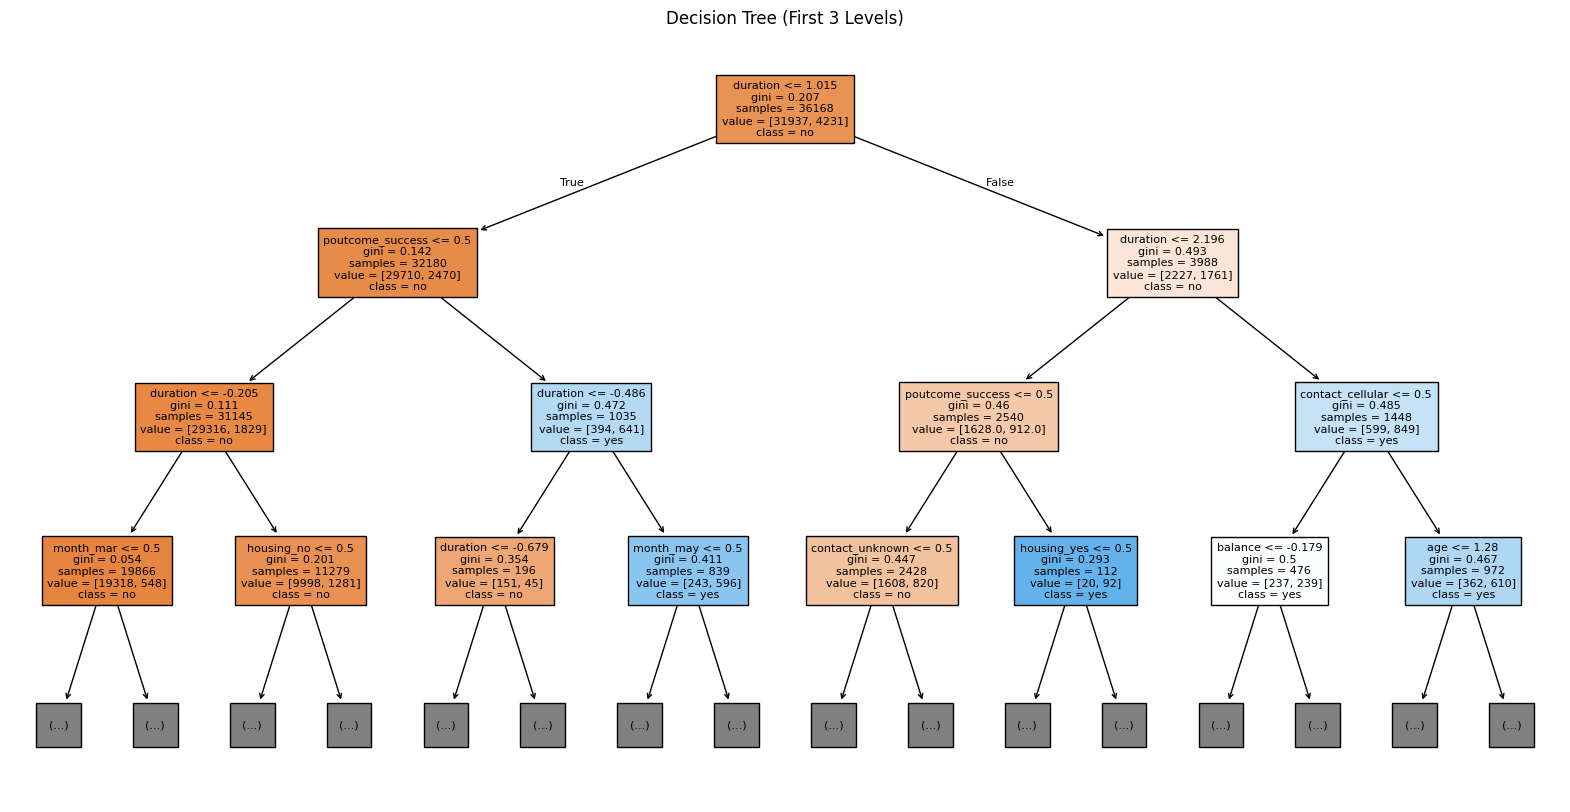


Trained model saved to: tree_model.joblib


In [ ]:
plt.figure(figsize=(20, 10))
tree = best.named_steps["clf"]
plot_tree(tree, feature_names=feature_names, class_names=["no", "yes"],
          filled=True, max_depth=3, fontsize=8)
plt.title("Decision Tree (First 3 Levels)")
plt.show()

# ------------------------------
# 11. Save trained model
# ------------------------------
save_path = "tree_model.joblib"
joblib.dump(best, save_path)
print(f"\nTrained model saved to: {save_path}")